# Estimating COVID-19's $R_t$ in Real-Time
Kevin Systrom - April 12

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) change $R_t$. Knowing the current $R_t$ is essential. When $R>1$, the pandemic will spread through the entire population. If $R_t<1$, the pandemic will grow to some fixed number less than the population. The lower $R_t$, the more manageable the situation. The value of $R_t$ helps us (1) understand how effective our measures have been controlling an outbreak and (2) gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, to my knowledge there is no real-time tracking of $R_t$ in United States. In fact, the only real-time measure I've seen has been for [Hong Kong](https://covid19.sph.hku.hk/dashboard). More importantly, it is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) level granularity of $R_t$.

What follows is a solution to this problem at the US State level. It's a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R_t$ using a Bayesian approach. While I have stayed true to most of their process, my solution differs in an important way that I will call out clearly.

If you have questions, comments, or improvments feel free to get in touch: [hello@systrom.com](mailto:hello@systrom.com). And if it's not entirely clear, I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so calibrate accordingly. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere – internationally or to counties in the United States.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

%config InlineBackend.figure_format = 'retina'

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


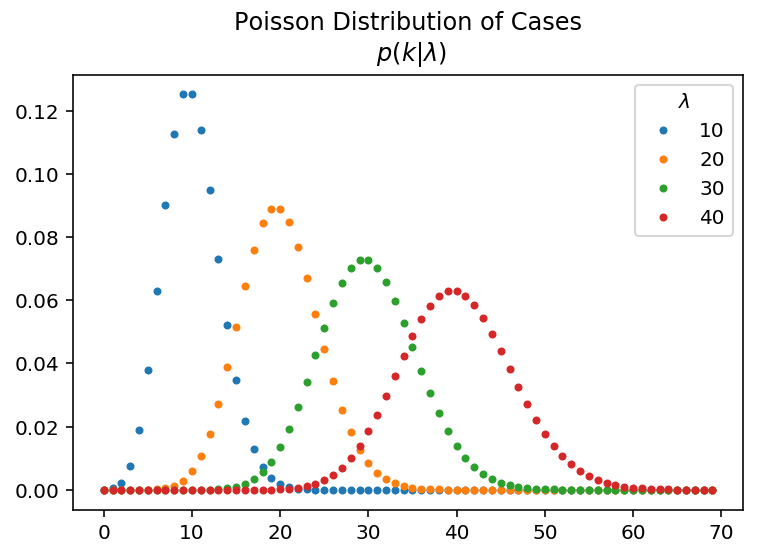

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

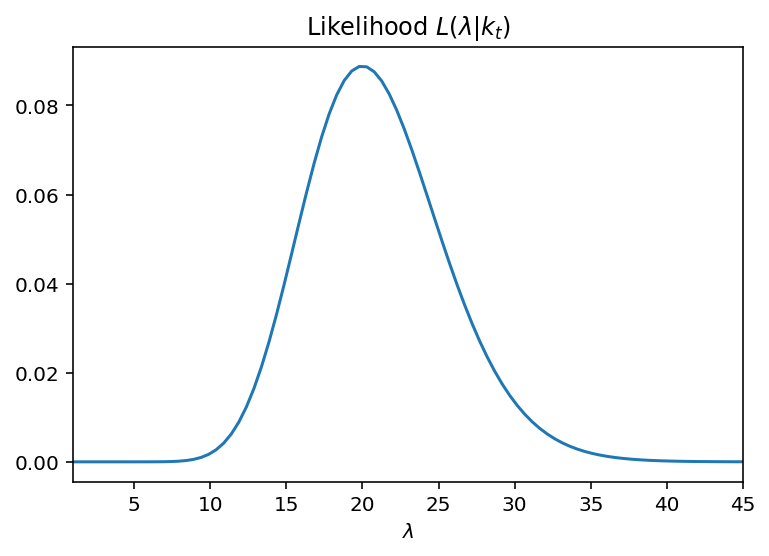

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $L\left(\lambda|k_t\right)$');

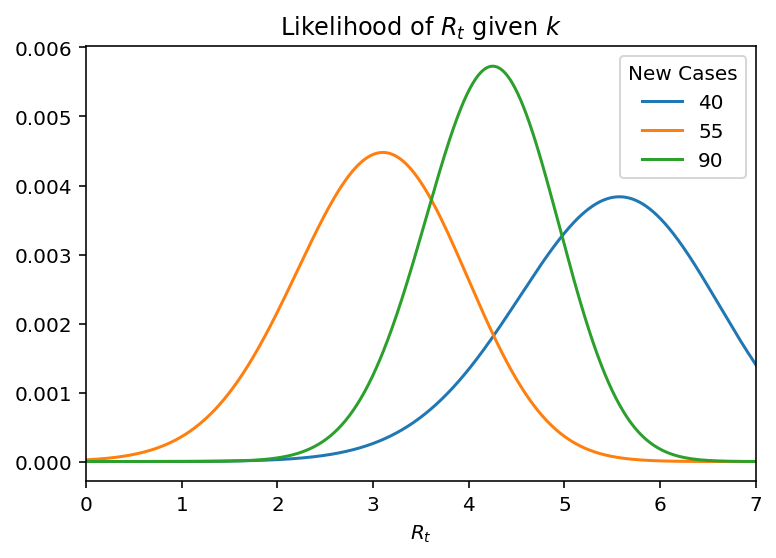

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 8
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# paper by Marco and Stefano
GAMMA = 1/6.6

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,7)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

You can see that each day we have a independent guesses for $R_t$. The goal is to combine the information we have about previous days with the current day. To do this, we use Bayes' theorem.

### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood) to get the posteriors. Let's do that using the cumulative product of each successive day:

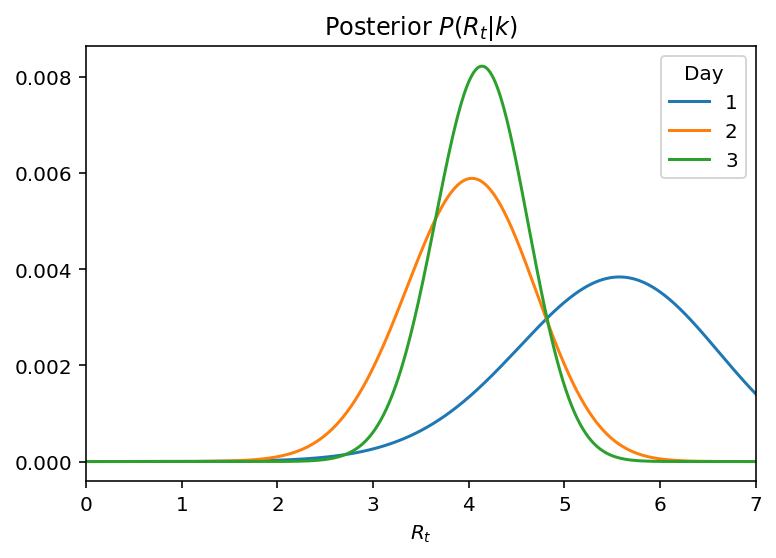

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,7)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

In [7]:
most_likely_values = posteriors.idxmax(axis=0)

In [8]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

hdi = highest_density_interval(posteriors, p=.95)

# Real-World Application to Italian data

### Setup

Load Italian data from the public repo of the Protezione Civile https://github.com/pcm-dpc/COVID-19

In [9]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
states = pd.read_csv(url,
                     usecols=[0,11],
                     index_col=['data'],
                     parse_dates=['data'],
                     squeeze=True).sort_index()

In [10]:
states=states.tshift(-14, freq='D')

In [13]:
state_name = 'Italy'

In [14]:
def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

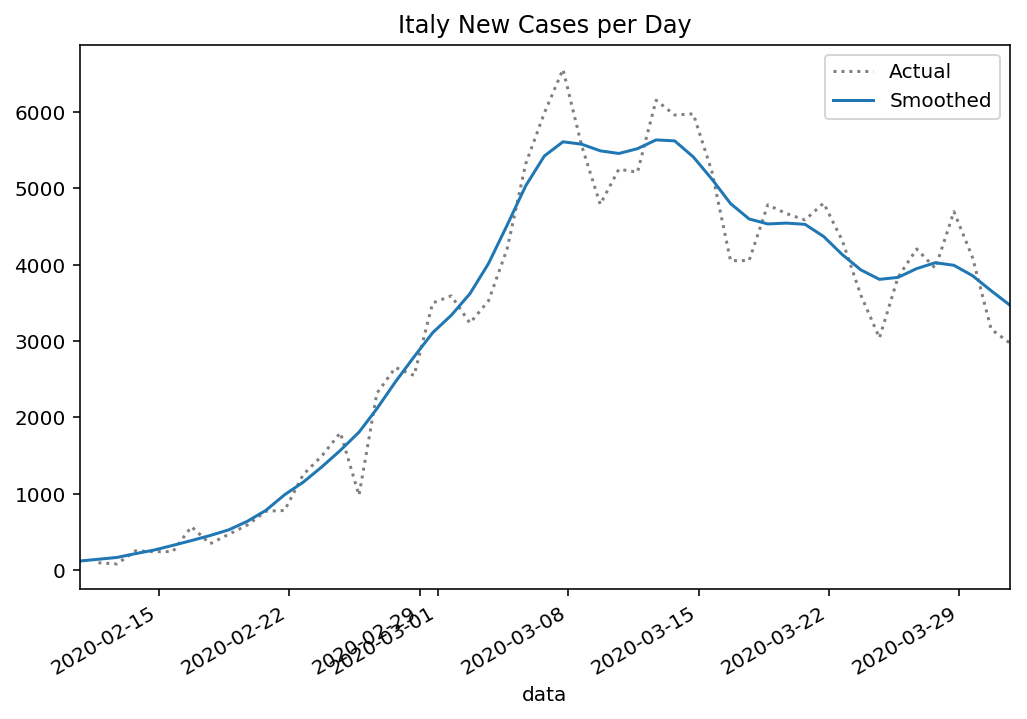

In [15]:
cases = states.rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Running the Algorithm

Just like the example before, we create lambda based on the previous day's counts from all values of $R_t$. Unlike the previous example, I now evaluate the __log__ of the Poisson. Why? It makes windowing easier.

Since $\log{ab}=\log{a}+\log{b}$, we can do a rolling sum over the last $m$ periods and then exponentiate to get the rolling product of the original values. This does not change any of the numbers – it's just a convenience.

In [16]:
def get_posteriors(sr, window=7, min_periods=1):
    
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

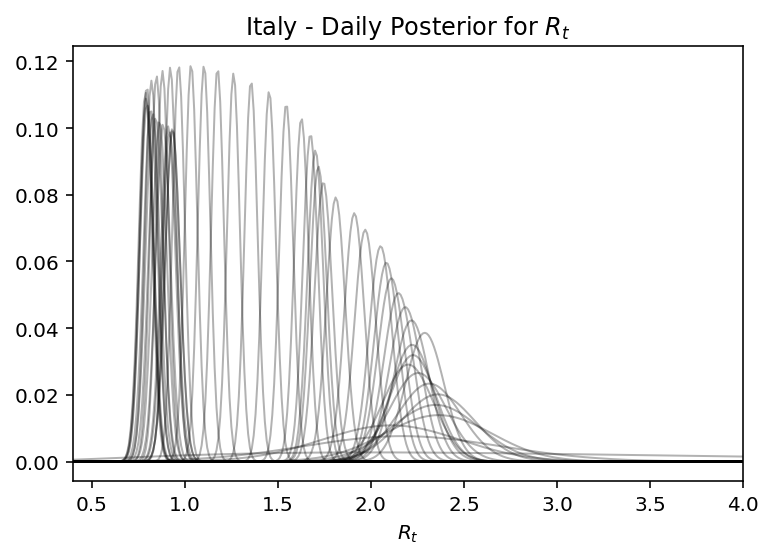

In [17]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [18]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
data,,,
2020-03-27 17:00:00,0.88,0.80,0.96
2020-03-28 17:00:00,0.91,0.83,0.99
2020-03-29 17:00:00,0.93,0.85,1.01
2020-03-30 17:00:00,0.93,0.85,1.01
2020-03-31 17:00:00,0.92,0.83,0.99


In [26]:
today=str(pd.to_datetime('today').date())

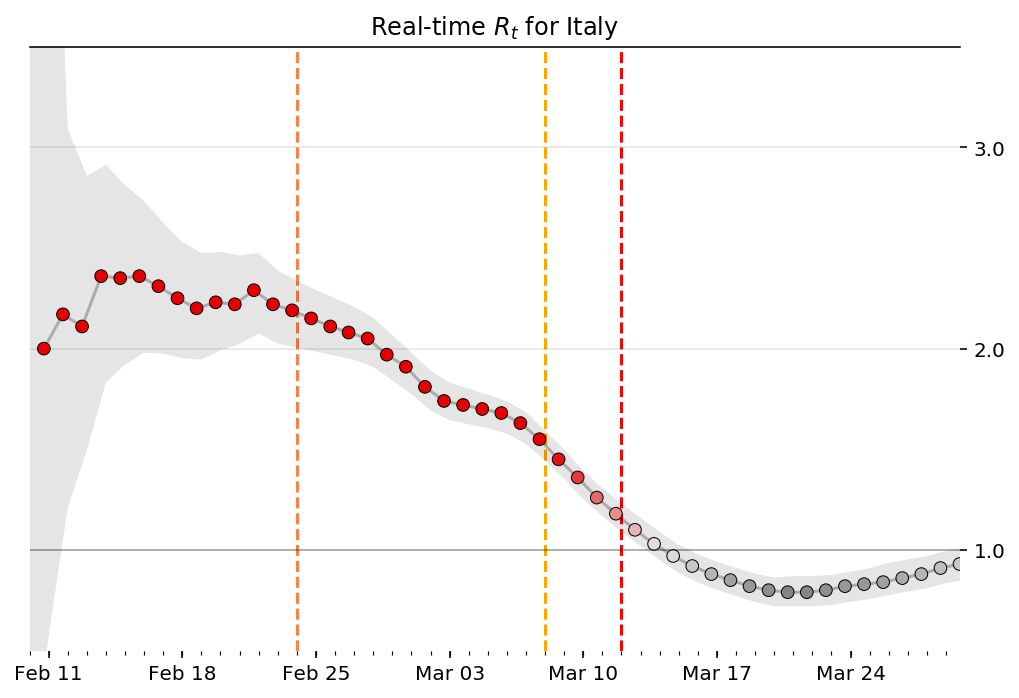

In [19]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    ax.axvline('2020-02-24', ls='--', color='coral', lw=1.5, zorder=0)
    ax.axvline('2020-03-08', ls='--', color='orange', lw=1.5, zorder=0)
    ax.axvline('2020-03-12', ls='--', color='red', lw=1.5, zorder=0)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                    result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                     result['High'].values,
                     bounds_error=False,
                    fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-10'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-02-10'), result[:-3].index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.savefig('./Figures/Rt_'+state_name'_'+today+'.png')